In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import matplotlib.patches as patches
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

import surprise as sup

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# load population scores

In [2]:
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_{resolution}_scores.csv"
scores = pd.read_csv(fpath)
print(f"{scores.shape=}")

bin_map = dict(zip(scores['bin_name'].values, scores['bin'].values))

scores.head()

scores.shape=(2431, 36)


,bin_name,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# Load expression data

In [3]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/expression_table/rna_table.parquet"
tdf = pd.read_parquet(fpath)
print(f"(raw) {tdf.shape=}")
print(f"(filtered) {tdf.shape=}")

expression_map = dict(zip(tdf['gene_name'].values, tdf['TPM'].values))

tdf.sample(5)

(raw) tdf.shape=(51883, 19)
(filtered) tdf.shape=(51883, 19)


,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation,ens_gene_id,gene_name
16190,ENSMUSG00000056770.15,"ENSMUST00000071095.13,ENSMUST00000109879.7,ENS...",2606.51,2354.75,1604.96,50.48,37.64,1604.96,0.19,48.48,37.91,45.796400,51.237000,0.019318,35.814000,40.063200,0.019296,ENSMUSG00000056770,Setd3
38796,ENSMUSG00000104134.1,ENSMUST00000193525.1,535.00,283.30,0.00,0.00,0.00,0.00,0.00,0.25,0.19,0.000005,0.738412,0.656498,0.000004,0.577008,0.656660,ENSMUSG00000104134,Gm2328
31531,ENSMUSG00000094532.1,ENSMUST00000168926.1,918.00,666.24,0.00,0.00,0.00,0.00,0.00,0.11,0.08,0.000005,0.311330,0.651906,0.000004,0.243459,0.651976,ENSMUSG00000094532,Vmn1r259
28339,ENSMUSG00000087765.1,ENSMUST00000157140.1,124.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSMUSG00000087765,Gm23985
30072,ENSMUSG00000091471.1,ENSMUST00000166808.1,225.00,11.40,0.00,0.00,0.00,0.00,0.00,6.15,4.81,0.000132,18.406700,0.654711,0.000103,14.394700,0.654742,ENSMUSG00000091471,Gm20538


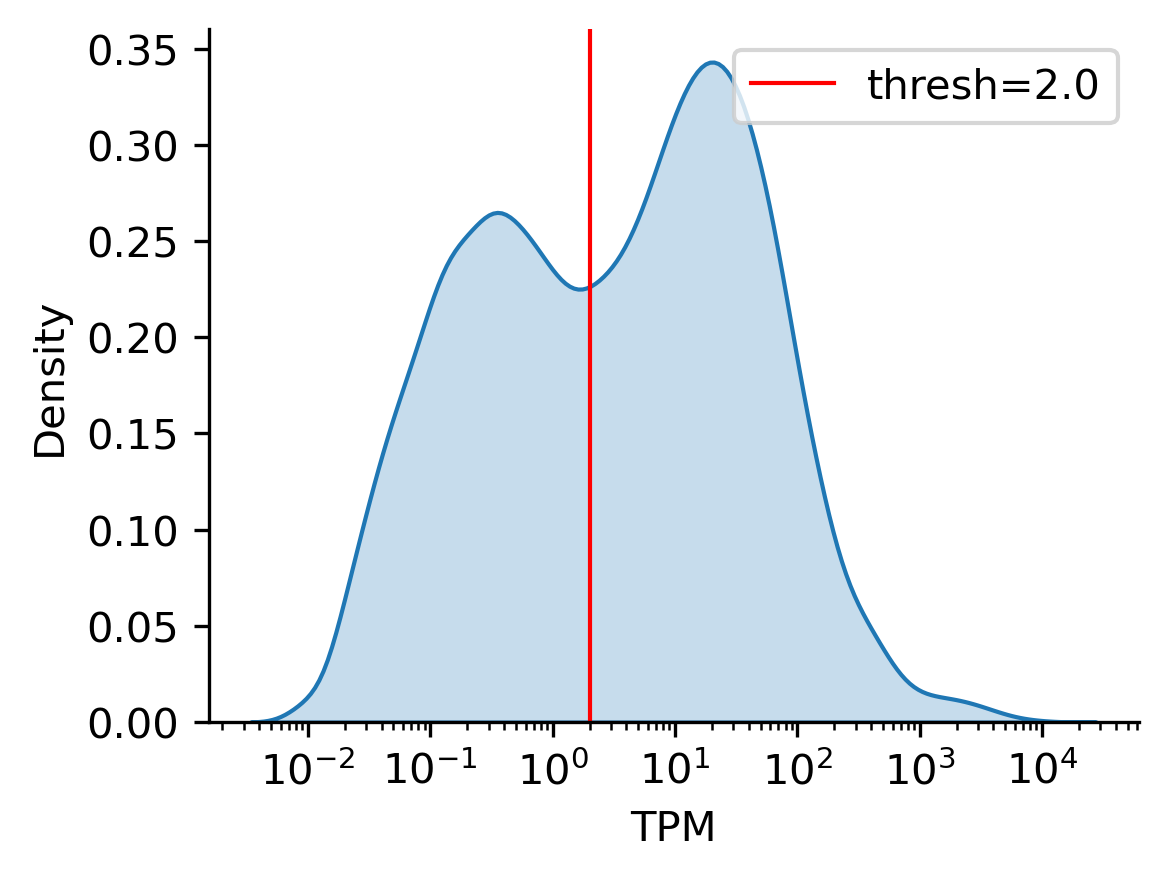

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4 ,3

sns.kdeplot(
    data=tdf[tdf['TPM'] > 0], 
    x='TPM',
    fill=True,
    log_scale=True,
)

thresh = 2.0
plt.axvline(x=2.0, c='r', lw=1, label=f"{thresh=}")
plt.legend(loc='upper right')
sns.despine()

# load population gene mapping

In [5]:
""" LOAD the TF list """
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"
tf_list = [x.strip() for x in open(fpath)]

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)

""" MERGE the core scores """
merge_columns = [
    'bin_name',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_5',
    'global_hge_logexp_RNA_weighted'
]

df = pd.merge(
    df, scores[merge_columns].fillna(0.0), how="left",
)

""" DEFINE the core """
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(df[score_column].fillna(0.0), core_threshold_quantile)
df['is_core'] = df[score_column].fillna(0.0) > threshold

print(df['is_core'].value_counts())

"""ADD some convience columns """
df['chrom'] = df['bin_name'].str.split(":").str[0]
df['bin'] = df['bin_name'].map(bin_map)
df['expression'] = df['gene_name'].map(expression_map)

print(f"{df.shape=}")
df.head()

is_core
False    3704772
True     1234495
Name: count, dtype: int64
df.shape=(4939267, 15)


,gene_name,gene_biotype,read_name,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,chrom,bin,expression
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,0.826484,1.149226,1.349552,0.866066,0.573875,0.254849,False,chr9,1394.0,4.12
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,0.497386,0.547185,0.336787,0.839273,0.141617,0.157878,False,chr19,2436.0,4.55
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,0.754788,1.027046,1.577616,0.839461,0.906364,0.491722,True,chr4,665.0,87.94
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,0.690311,0.851758,0.774613,0.833768,0.617768,0.310082,False,chr12,1659.0,NaN
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,0.767515,0.921479,1.337415,0.571748,0.508463,0.289030,False,chr17,2289.0,23.16


# Summarize gene mapping

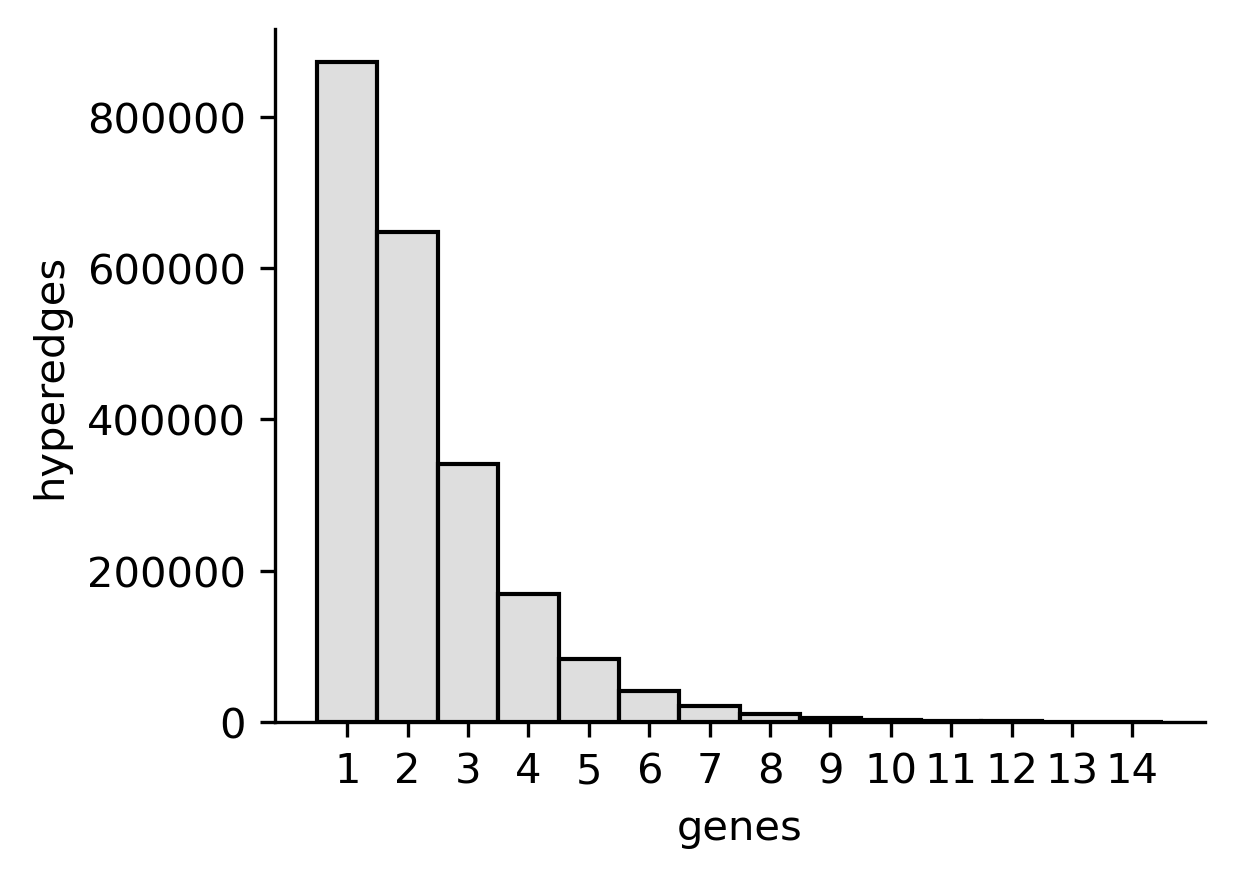

In [6]:
order = df.groupby('read_name')['gene_name'].nunique()

threshold = 15

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(
    data=order[order < threshold],
    discrete=True,
    color='lightgrey',
)

ax = plt.gca()
ax.set_xticks(range(min(order[order < threshold]), max(order[order < threshold])+1))

plt.ylabel('hyperedges')
plt.xlabel('genes')
sns.despine()

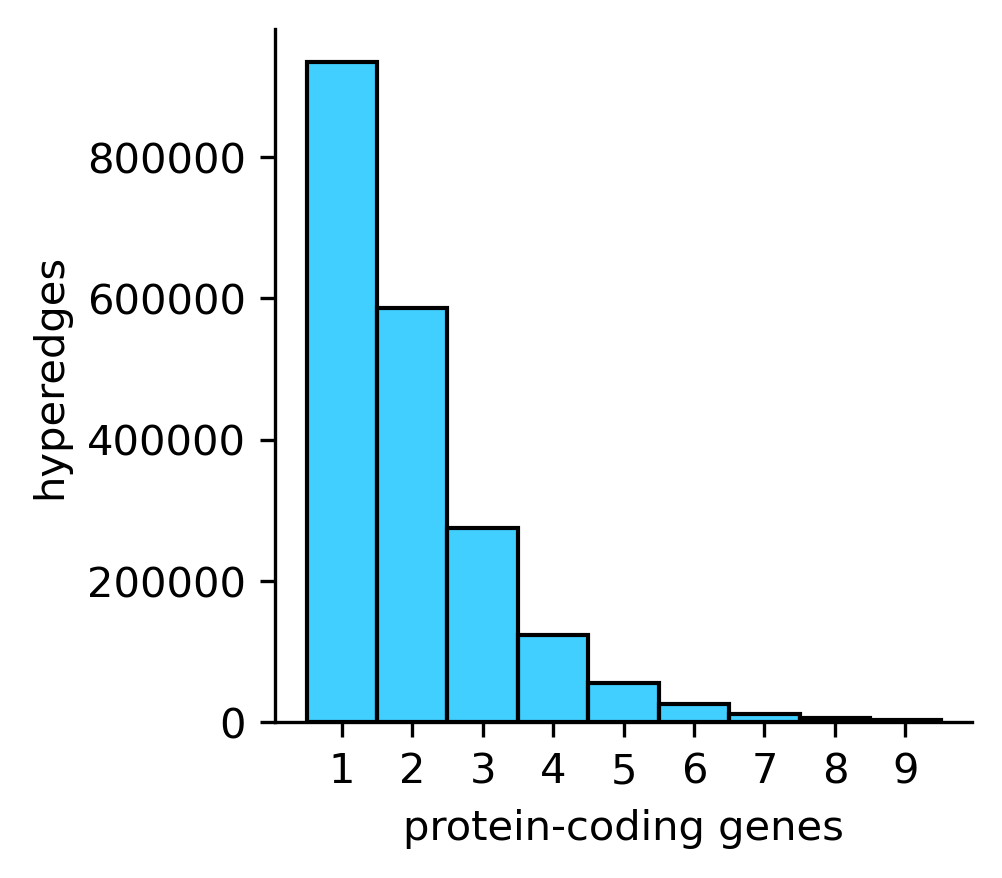

In [7]:
order = df[df['gene_biotype'] == 'protein_coding'].groupby('read_name')['gene_name'].nunique()

threshold = 10

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.histplot(
    data=order[order < threshold],
    discrete=True,
    color='deepskyblue',
)

ax = plt.gca()
ax.set_xticks(range(min(order[order < threshold]), max(order[order < threshold])+1))

plt.ylabel('hyperedges')
plt.xlabel('protein-coding genes')
sns.despine()

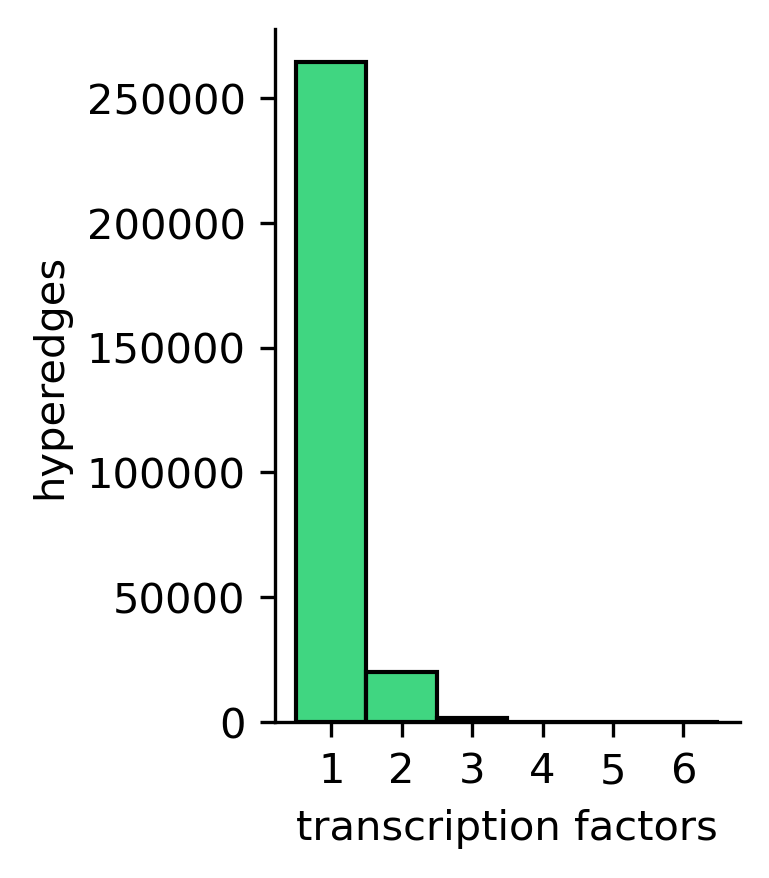

In [8]:
order = df[df['is_tf']].groupby('read_name')['gene_name'].nunique()

threshold = 7

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3

sns.histplot(
    data=order[order < threshold],
    discrete=True,
    color='#00C957',
)

ax = plt.gca()
ax.set_xticks(range(min(order[order < threshold]), max(order[order < threshold])+1))

plt.ylabel('hyperedges')
plt.xlabel('transcription factors')
sns.despine()

In [9]:
""" How many of the genes are expressed? """
threshold = 5.0

genes = df.copy()
genes = genes[['gene_name', 'gene_biotype', 'expression']].drop_duplicates()
genes['expression'] = genes['expression'].fillna(0.0)
genes['is_expressed'] = genes['expression'] > threshold

print(f"{genes.shape=}")

print(genes['is_expressed'].value_counts())
print()
print(genes['is_expressed'].value_counts(normalize=True))

print()
print(genes[['gene_biotype', 'is_expressed']].value_counts(normalize=False))

genes.head()

genes.shape=(47398, 4)
is_expressed
False    37871
True      9527
Name: count, dtype: int64

is_expressed
False    0.799
True     0.201
Name: proportion, dtype: float64

gene_biotype                        is_expressed
protein_coding                      False           12272
lncRNA                              False           10276
protein_coding                      True             9045
processed_pseudogene                False            7484
TEC                                 False            2801
unprocessed_pseudogene              False            1880
snRNA                               False             643
snoRNA                              False             525
miRNA                               False             495
processed_pseudogene                True              268
misc_RNA                            False             227
transcribed_unprocessed_pseudogene  False             223
IG_V_gene                           False             205
transcribed_processed_pseud

,gene_name,gene_biotype,expression,is_expressed
0,Ulk4,protein_coding,4.12,False
1,Smarca2,protein_coding,4.55,False
2,Dlgap3,protein_coding,87.94,True
3,Gm56531,lncRNA,0.00,False
4,Twsg1,protein_coding,23.16,True


# Identify the core tf clusters

In [10]:
tf = 1
d = 2
t = 2.0
chroms = 1

"""criteria:
    1. one TF
    2. d protien-coding genes in the core with expression over t
    3. multiple-chromosomes
"""

core = df.copy()
print(f"(raw) {core.shape=}")
core = core[core['expression'].notna()]
core = core[core['gene_biotype'] == 'protein_coding']
core['is_expressed'] = core['expression'] > t

core = core.groupby('read_name').agg(
    chroms = ('chrom', 'nunique'),
    tf = ('is_tf', 'sum'),
    core = ('is_core', 'sum'),
    expressed = ('is_expressed', 'sum'),
    mean_expression = ('expression', 'mean'),
).reset_index()

print(f"(grouped) {core.shape=}")

core = core[core['tf'] >= tf]
core = core[core['core'] >= d]
core = core[core['expressed'] >= t]
core = core[core['chroms'] >= chroms]

print(f"(filtered) {core.shape=}")

core.head()

(raw) core.shape=(4939267, 15)
(grouped) core.shape=(2021658, 6)
(filtered) core.shape=(38582, 6)


,read_name,chroms,tf,core,expressed,mean_expression
28,0000c863-d9dd-4589-8307-614a9f5db5b1,4,1,2,2,7.8320
90,0003060b-d552-48f5-a116-6219ff00b425,4,1,2,4,3.2060
166,00055dd1-0900-4c4c-986f-2d31b8093830,1,1,2,2,6.9375
180,00059de3-2ef6-47be-b133-27b1dbb5d212,4,3,2,4,87.3140
217,0006c00f-8c61-4d94-946b-8b056e4a292c,3,1,3,3,16.5660


Fri Jan 10 14:50:33 2025 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Fri Jan 10 14:50:33 2025 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


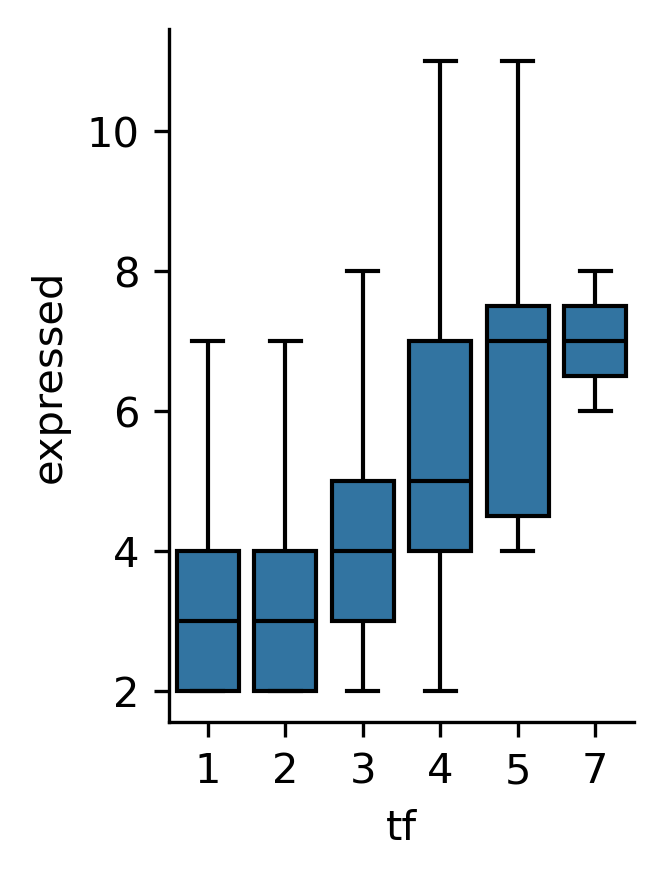

In [11]:
sns.boxplot(
    data=core,
    x='tf',
    y='expressed',
    linecolor='k',
    showfliers=False,
    flierprops=dict(marker='.', markerfacecolor='grey', markersize=1)
)
sns.despine()

# Summarize

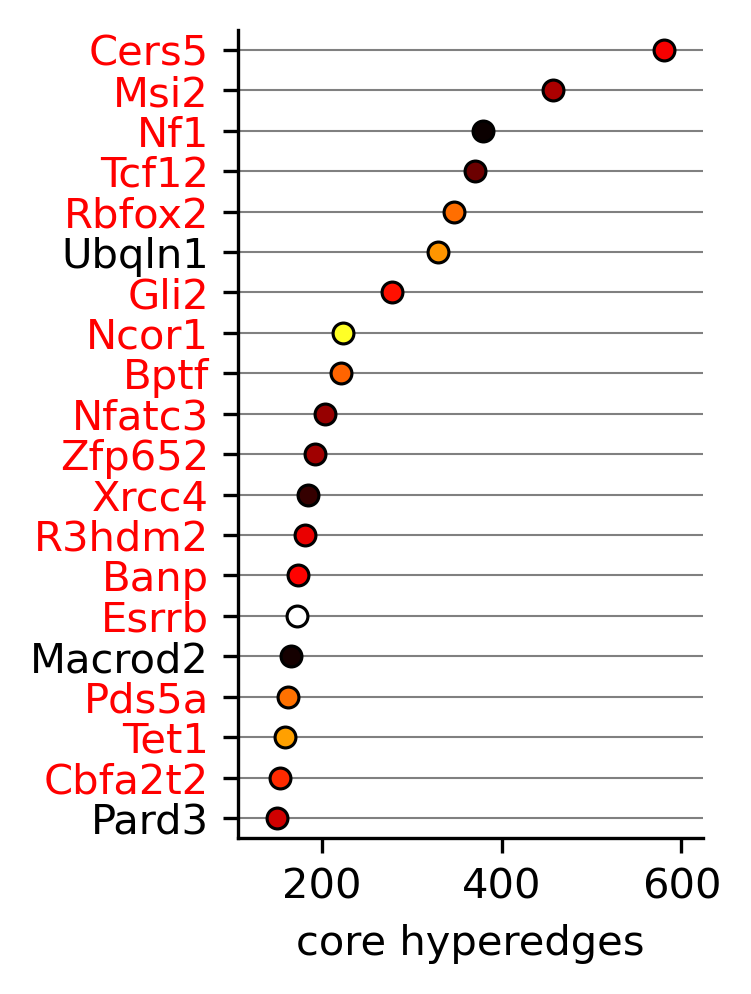

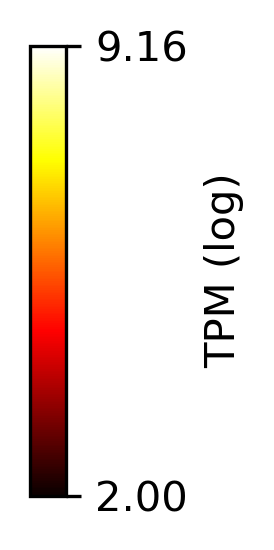

In [12]:
H = df[df['read_name'].isin(core['read_name'].values)].copy()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 3.5

n_plot = 20
cmap = 'hot'

plot = H['gene_name'].value_counts().reset_index(drop=False)
plot['expression'] = plot['gene_name'].map(expression_map)
plot['is_tf'] = plot['gene_name'].isin(tf_list)
plot['expression'] = np.log1p(plot['expression'].astype(float))
plot = plot[plot['expression'] > t]

sns.stripplot(
    data=plot.head(n_plot),
    y='gene_name',
    x='count',
    hue='expression',
    edgecolor='k',    
    palette=cmap,
    size=5,
    linewidth=0.75,
    legend=False,
)

# Get the y-tick labels
yticklabels = plt.gca().get_yticklabels()

# Iterate through the labels and change color based on 'is_tf'
for i, label in enumerate(yticklabels):
    gene_name = label.get_text()
    if plot[plot['gene_name'] == gene_name]['is_tf'].values[0]:
        label.set_color('red')

plt.grid(axis='y', color='grey', linestyle='-', linewidth=0.5)
plt.margins(x=0.1)
plt.ylabel('')
plt.xlabel('core hyperedges')
sns.despine()
plt.show()

reload(plt2)
plt2.make_colorbar(
    cmap=cmap,
    width=0.15,
    height=2.5,
    title='TPM (log)',
    orientation='vertical',
    tick_labels=[f"{plot['expression'].min():.2f}",
                f"{plot['expression'].max():.2f}"],
)


In [13]:
database = 'celltypes'
n_query = 25

edf = gget.enrichr(plot['gene_name'].head(n_query).to_list(), database=database)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

Fri Jan 10 14:50:35 2025 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,Embryonic Stem Cells,0.001332,"[RBFOX2, PARD3, ESRRB, GLI2]"
1,Kidney Progenitor Cells,0.026607,"[RBFOX2, GLI2]"
2,Motor Neurons,0.026607,"[RBFOX2, GLI2]"
3,Granulosa Cells,0.026607,"[RBFOX2, GLI2]"
4,Endothelial Cells (Blood Brain Barrier),0.026607,"[RBFOX2, PPARD]"
5,Cardiac Stem And Precursor Cells,0.026607,"[RBFOX2, GLI2]"
6,Peri-islet Schwann Cells,0.026607,"[RBFOX2, GLI2]"
7,Oxyphil Cells,0.186772,[ESRRB]
8,His Bundle Cells,0.186772,[GLI2]
9,Osteocytes,0.186772,[GLI2]


In [14]:
query = [
    'Sox5',
    'Hivep3',
    'Msi2',
]
query = tdf[tdf['gene_name'].isin(query)][['gene_name', 'TPM' , 'TPM_ci_lower_bound', 'TPM_ci_upper_bound',]].head()
print(query.to_string(index=False))

gene_name   TPM  TPM_ci_lower_bound  TPM_ci_upper_bound
   Hivep3  0.34            0.837018             8.18403
     Sox5  0.04            0.423750             3.11353
     Msi2 18.49           16.623900            20.76460


# Whose the most within the core

In [20]:
def make_incidence(df):
    df['value'] = 1
    df['read_index'] = df['read_name'].astype('category').cat.codes
    df['gene_index'] = df['gene_name'].astype('category').cat.codes
    
    data = df['value'].tolist()
    row = df['gene_index'].values
    col = df['read_index'].values
    
    n = df['gene_index'].nunique()
    m = df['read_index'].nunique()
    
    index = df['gene_name'].unique()
    columns = df['read_name'].unique()
    
    X = csr_matrix((data, (row, col)), shape=(n, m))
    X = csr_matrix((X > 0).astype(int))
    H = pd.DataFrame.sparse.from_spmatrix(
        X, index=index, columns=columns,
    )
    del X
    del data
    del row
    del col
    del index
    del columns
    return H

order_threshold = 3.0
H = df[df['read_name'].isin(core['read_name'].values)].copy()
H = make_incidence(H)
print(f"(raw) {H.shape=}")

H = H[H.columns[H.sum(axis=0) >= order_threshold]]
H = H.T.drop_duplicates().T
print(f"(filtered) {H.shape=}")

outpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/sparse_hypergraph.pkl"
H.to_pickle(outpath)

H.head()

(raw) H.shape=(24415, 38582)
(filtered) H.shape=(24415, 35343)


,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,c160a170-5af7-412b-9c03-36dfef017384,a8241f5d-1189-49c9-a948-c6a1c91cdf17,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,77bc1796-a0a3-4140-a97b-d4a786d17cb2,4f913e8a-799a-488e-a7bd-6ae9566e5c37,a425bdc9-37ea-4020-bc7c-5085fb99a3c7,8ad994fd-c214-46f9-99b0-37c2b3f2946e,b11c9d23-365a-44f5-ace6-217680ce31e8,c0af4b45-8929-41d6-982f-8a5ba6051d41,...,6e74d129-3498-42b0-ade9-0d35f60543af,eae8359f-2057-4492-93d1-10437e892f0b,01f1812f-b821-493c-bc17-3e5e6d453f2c,fcf0a060-2833-4ff0-a352-d5e702f27f46,6199d009-7ef7-44f6-b10c-c0ac846f362c,06857eb1-74b5-484c-9eb3-b0ced3498887,689b7cde-4f15-4869-bda9-bb49cf4e5676,9f9a0a4e-630b-406a-bb24-7026948c9787,acfb51fd-375f-42ac-839c-326616ea1953,de0a50ba-dade-46ba-9ed2-583b92b669b2
Smarca2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sh2d5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ppp1r15b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dyrk1a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Igf2bp3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
cdf = pd.DataFrame({
    'gene_name' : H.index,
    'expression' : H.index.map(expression_map),
    'is_tf' : H.index.isin(tf_list),
})

node, edge = central.nonlinear_eigenvector_centrality(
    H, function='log-exp',
)

cdf['score'] = node
cdf['norm_score'] = ut.min_max(node)
cdf = cdf.sort_values(by='norm_score', ascending=False)
cdf = cdf.reset_index(drop=True)

outpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/node_centralities.parquet"
cdf.to_parquet(outpath)

cdf.head(5)

,gene_name,expression,is_tf,score,norm_score
0,Zfp111,5.62,True,0.000175,1.000000
1,Gm7803,0.30,False,0.000166,0.952722
2,Sfxn5,1.18,False,0.000165,0.942303
3,Gm35769,0.00,False,0.000164,0.941602
4,Gm26650,0.00,False,0.000163,0.934134


In [22]:
cdf[cdf['is_tf']].head(5)

,gene_name,expression,is_tf,score,norm_score
0,Zfp111,5.62,True,0.000175,1.000000
36,Zbtb24,14.82,True,0.000143,0.821778
38,Gtf2i,82.72,True,0.000143,0.820282
47,Zbtb7b,22.20,True,0.000142,0.815461
49,Prox2,0.15,True,0.000142,0.814416


# get the hyperedges

In [23]:
cdf = pd.DataFrame({
    'read_name' : H.columns,
    'score' : edge,
    'norm_score' : ut.min_max(edge),
    'order' : H.sum(axis=0),
})

cdf = cdf.sort_values(by='norm_score', ascending=False)
cdf = cdf.reset_index(drop=True)

outpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/core_of_core/edge_centralities.parquet"
cdf.to_parquet(outpath)

cdf.head()

,read_name,score,norm_score,order
0,447e44a1-c2bb-4604-acdd-48ee4d5a8569,0.000377,1.000000,3
1,d16238ba-3f72-4d62-a57a-f57ac2852da9,0.000361,0.957175,3
2,f32fce98-d99e-4341-ade9-bab53af61864,0.000355,0.941541,3
3,4accbf99-112a-4454-8eab-2861658368fb,0.000347,0.920801,3
4,a320d93f-1307-411a-93cb-76a62b6d6b88,0.000338,0.896880,3


In [19]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
database = 'celltypes'
n_query = 100

edf = gget.enrichr(cdf['gene_name'].head(n_query).to_list(), database=database)
edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(5)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.4, 2

sns.boxplot(
    data=cdf, 
    y='score',
    x='is_tf',
    showfliers=False,
)

# Visualize

In [ ]:
sample_size = 1000

H = df[df['read_name'].isin(core['read_name'].values)].copy()
print(f"{H.shape=}")
print(f"{H['gene_name'].nunique()=}")

sample_reads = np.random.choice(H['read_name'].unique(), sample_size, replace=False)
H = H[H['read_name'].isin(sample_reads)]

H['min_bin'] = H.groupby('read_name')['bin'].transform('min')
H = H.sort_values(by=['read_name', 'min_bin'], ascending=[True, False])
H['read_index'] = H['read_name'].astype('category').cat.codes

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 7

sns.scatterplot(
    data=H,
    x='read_index',
    y='gene_name',
    s=7,
    ec='none',
    hue='is_tf',
    palette=['grey', 'r'],
)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

# H.head()

In [ ]:
break

# core vs expression

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'is_core', ]].drop_duplicates()
pdf['expression'] = np.log1p(pdf['gene_name'].map(expression_map))

print(f"{pdf.shape=}")
print(f"{pdf['is_core'].value_counts()}")
print()
print(f"{pdf['is_core'].value_counts(normalize=True)}")

# Perform t-test
core_expression = pdf[pdf['is_core'] == True]['expression'].fillna(0.0)
non_core_expression = pdf[pdf['is_core'] == False]['expression'].fillna(0.0)
t_stat, p_value = scipy.stats.ttest_ind(core_expression, non_core_expression)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.3f}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.boxplot(
    data=pdf,
    x='is_core',
    y='expression',
    hue='is_core',
    showfliers=False,
    palette=['lightgrey', 'red'],
    linecolor='k',
    width=0.5,
    legend=False,
)

plt.ylabel('expression (log TPM)')
plt.xlabel('')
plt.gca().set_xticklabels(['non-core', 'core'])

sns.despine()
pdf.head()

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'ATACSeq_1', 'CTCF', 'H3K27ac', 'is_core', 'global_hge_logexp_RNA_weighted']].drop_duplicates()
pdf['expression'] = pdf['gene_name'].map(expression_map)

pdf = pdf.sort_values(by='global_hge_logexp_RNA_weighted')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=pdf,
    x='ATACSeq_1',
    y='expression',
    ec='none',
    palette='hot',
    hue='global_hge_logexp_RNA_weighted',
    s=5,
    legend=False,
)

plt.yscale('log')

plt.ylabel('TPM (log)')
plt.xlabel('ATAC-seq')
sns.despine()

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'is_core', ]].drop_duplicates()
pdf['expression'] = np.log1p(pdf['gene_name'].map(expression_map))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1, 2

sns.boxplot(
    data=pdf,
    x='is_core',
    y='expression',
    hue='is_core',
    showfliers=False,
    width=0.5,
)

pdf.head()

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'ATACSeq_1', 'CTCF', 'H3K27ac', 'is_core', 'global_hge_logexp_RNA_weighted']].drop_duplicates()
pdf['expression'] = pdf['gene_name'].map(expression_map)
pdf = pdf[pdf['expression'] > 0]
pdf = pdf[pdf['ATACSeq_1'] > 0]

pdf = pdf.sort_values(by='global_hge_logexp_RNA_weighted')

sns.histplot(
    data=pdf,
    kde=True,
    x='ATACSeq_1',
    y='expression',
    bins=101,
    log_scale=(True, False),
    palette='hot',
    hue='is_core',
)